In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.base import BaseEstimator, ClassifierMixin 
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, get_scorer
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier

In [3]:
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
dataset = pd.read_csv('../data/iris/iris.data', header=None, names=column_names)
dataset.head()
    

sepal_length  sepal_width  petal_length  petal_width        class
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

In [4]:
features = dataset.drop('class', axis=1)
targets = dataset['class']

In [5]:
targets.value_counts()

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: count, dtype: int64

array([[<Axes: title={'center': 'sepal_length'}>,
        <Axes: title={'center': 'sepal_width'}>],
       [<Axes: title={'center': 'petal_length'}>,
        <Axes: title={'center': 'petal_width'}>]], dtype=object)

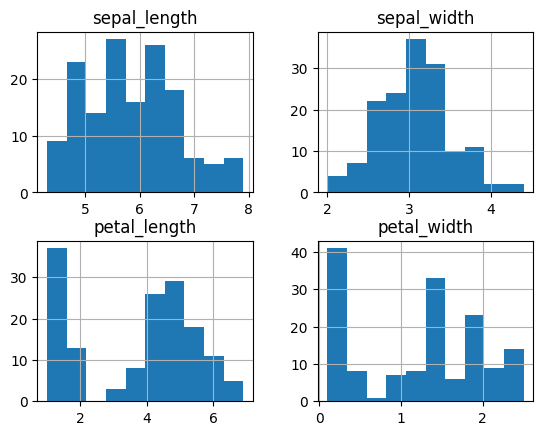

In [8]:
# features.plot.hist()
features.hist()

In [10]:
correlation = features.corr()
correlation.style.background_gradient('coolwarm')

In [11]:
features = (features - features.mean()) / features.std()
features.describe()

sepal_length   sepal_width  petal_length   petal_width
count  1.500000e+02  1.500000e+02  1.500000e+02  1.500000e+02
mean  -5.684342e-16 -7.815970e-16 -2.842171e-16 -3.789561e-16
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00
min   -1.863780e+00 -2.425820e+00 -1.562342e+00 -1.442245e+00
25%   -8.976739e-01 -5.903951e-01 -1.222456e+00 -1.179859e+00
50%   -5.233076e-02 -1.315388e-01  3.353541e-01  1.320673e-01
75%    6.722490e-01  5.567457e-01  7.602115e-01  7.880307e-01
max    2.483699e+00  3.080455e+00  1.779869e+00  1.706379e+00

In [ ]:
features_pca2 = pd.DataFrame(PCA(n_components=2).fit_transform(features))
features_pca3 = pd.DataFrame(PCA(n_components=3).fit_transform(features))

0             1             2
0  1.000000e+00  7.821135e-17 -5.009539e-17
1  7.821135e-17  1.000000e+00 -1.047831e-15
2 -5.009539e-17 -1.047831e-15  1.000000e+00

In [47]:
# A function for running tests on specified data
def evaluate(estimator, X, y):
    # Get the prediction probabilities for each class
    # probabilities = estimator.predict_proba(X)
    # Get the indices of the highest probabilities for each prediction
    # prediction_indices = np.argmax(probabilities, axis=1)
    # Build a list with the appropriate class labels for each prediction
    # predictions = estimator.classes_.take(prediction_indices, axis=0) 
    predictions = estimator.predict(X)

    return {
        'accuracy': accuracy_score(y, predictions), 
        # 'precision': precision_score(y, predictions), 
        # 'recall': recall_score(y, predictions), 
        # 'f1': f1_score(y, predictions), 
        # 'roc_auc': roc_auc_score(y, probabilities[:,1]), 
        }

In [27]:
print(cross_val_score(DecisionTreeClassifier(), X=features, y=targets))
print(cross_val_score(DecisionTreeClassifier(), X=features_pca2, y=targets))
print(cross_val_score(DecisionTreeClassifier(), X=features_pca3, y=targets))
# cross_val_score(DecisionTreeClassifier(), X=features, y=targets, scoring=make_scorer(f1_score, average='micro'))
print(cross_val_score(GaussianNB(), X=features, y=targets))
print(cross_val_score(GaussianNB(), X=features_pca2, y=targets))
print(cross_val_score(GaussianNB(), X=features_pca3, y=targets))
print(cross_val_score(SVC(), X=features, y=targets))
print(cross_val_score(SVC(), X=features_pca2, y=targets))
print(cross_val_score(SVC(), X=features_pca3, y=targets))

[0.96666667 0.96666667 0.9        0.93333333 1.        ]
[0.9        0.9        0.9        0.76666667 0.96666667]
[0.96666667 0.96666667 0.86666667 0.93333333 1.        ]
[0.93333333 0.96666667 0.93333333 0.93333333 1.        ]
[0.86666667 0.93333333 0.86666667 0.86666667 0.93333333]
[0.9        0.96666667 0.9        0.93333333 1.        ]
[0.96666667 0.96666667 0.96666667 0.93333333 1.        ]
[0.86666667 0.96666667 0.86666667 0.9        0.96666667]
[0.96666667 0.96666667 0.96666667 0.93333333 1.        ]


In [38]:
global_random_state = 13
scoring = {
    'accuracy': get_scorer('accuracy'),
    'precision': get_scorer('precision'),
    'recall': get_scorer('recall'),
}

In [ ]:
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=13)

for (train_index, test_index) in outer_cv.split(features, targets):
    grid = GridSearchCV(
        DecisionTreeClassifier(), 
        # {'C': [0.1, 0.2, 0.4, 0.8, 1.6]}, 
        {'max_depth': [1,2,4]},
        scoring=scoring, 
        refit='accuracy',
        cv=inner_cv)
    grid.fit(features.iloc[train_index], targets.iloc[train_index])
    evaluation = evaluate(grid.best_estimator_, features.iloc[test_index], targets.iloc[test_index])
    print(evaluation)

    

/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/metrics/_classification.py", line 2524, in precision_score
    p, _, _, 

{'accuracy': 0.9333333333333333}
{'accuracy': 1.0}
{'accuracy': 0.8666666666666667}
{'accuracy': 0.9666666666666667}
{'accuracy': 0.9333333333333333}


/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:971: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 152, in __call__
    score = scorer._score(
        cached_call, estimator, *args, **routed_params.get(name).score
    )
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/metrics/_scorer.py", line 408, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/utils/_param_validation.py", line 218, in wrapper
    return func(*args, **kwargs)
  File "/home/lars/.venv/ml/lib/python3.13/site-packages/sklearn/metrics/_classification.py", line 2524, in precision_score
    p, _, _, 